# Analysis of Earthquake Frequency
### By Royce Schultz

The database is available on [Kaggle](https://www.kaggle.com/usgs/earthquake-database)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
# Determines Euclidian (straight line) between 2 points
# Input:
#   Dataframe with Latitude and Longitude components
#   2 arguments for Lat and Long of reference point
# Output:
#   Series containing distances to the reference point
def distance_from(df, Lat, Long):
    
    Lat = np.deg2rad(Lat) # Convert degrees to radians for numpy trig
    Long = np.deg2rad(Long)
    x_pos = np.cos(Lat)*np.sin(Long) # Convert spherical coordinates to cartesian
    y_pos = np.cos(Lat)*np.cos(Long) # Assumes earths radius = 1
    z_pos = np.sin(Lat)
    
    data_Latitude_rad = np.deg2rad(df.Latitude) # Convert dataframe to radians
    data_Longitude_rad = np.deg2rad(df.Longitude)
    data_x_pos = np.cos(data_Latitude_rad)*np.sin(data_Longitude_rad) # Convert to spherical
    data_y_pos = np.cos(data_Latitude_rad)*np.cos(data_Longitude_rad)
    data_z_pos = np.sin(data_Latitude_rad)
    return ( (data_x_pos - x_pos)**2 + (data_y_pos - y_pos)**2 + (data_z_pos - z_pos)**2)**(1/2) # Pythagoras3D

In [3]:
Fields = ['Date','Time','Latitude','Longitude','Type','Magnitude'] # Only import used columns
df = pd.read_csv('database.csv', usecols=Fields)
df.head()

,Date,Time,Latitude,Longitude,Type,Magnitude
0,01/02/1965,13:44:18,19.246,145.616,Earthquake,6.0
1,01/04/1965,11:29:49,1.863,127.352,Earthquake,5.8
2,01/05/1965,18:05:58,-20.579,-173.972,Earthquake,6.2
3,01/08/1965,18:49:43,-59.076,-23.557,Earthquake,5.8
4,01/09/1965,13:32:50,11.938,126.427,Earthquake,5.8


In [4]:
# Cleaning
df = df[df.Date.str.len() < 15] # Removes 3 rows with malformed dates
df = df[df.Type.isin(['Earthquake'])] # removes explosions and rock bursts

In [5]:
# Calculations
df['Datetime'] = pd.to_datetime(df.Date +' '+ df.Time)
df['Year'] = df['Datetime'].map(lambda x: x.year)

df['Rounded_Magnitude'] = np.floor(df.Magnitude)

df['Last_Quake'] = df.Datetime.diff()
df = df[df['Last_Quake'].notna()]
df['Last_Quake_sec'] = df['Last_Quake'].map(lambda x: x.total_seconds()) # Last Quake (s)

Tokyo = [35.67,139.65]
San_Fran = [37.77,-122.42]
Denver = [39.74,-104.99]
# Calculates straightline distance from a given Lat/Long point to each earthquake
# Assumes earth is a sphere with radius=1
# Does not consider arc length, just straight distance
# So the poles are 2 units apart, the equator is sqrt(2) from each pole, not pi and pi/2
df['Dist_Tokyo'] = distance_from(df,Tokyo[0],Tokyo[1])
df['Dist_San_Fran'] = distance_from(df,San_Fran[0],San_Fran[1])
df['Dist_Denver'] = distance_from(df,Denver[0],Denver[1])

df.reset_index(drop=True)

df.head()

,Date,Time,Latitude,Longitude,Type,Magnitude,Datetime,Year,Rounded_Magnitude,Last_Quake,Last_Quake_sec,Dist_Tokyo,Dist_San_Fran,Dist_Denver
1,01/04/1965,11:29:49,1.863,127.352,Earthquake,5.8,1965-01-04 11:29:49,1965,5.0,1 days 21:45:31,164731.0,0.612724,1.583197,1.702209
2,01/05/1965,18:05:58,-20.579,-173.972,Earthquake,6.2,1965-01-05 18:05:58,1965,6.0,1 days 06:36:09,110169.0,1.166416,1.228930,1.390338
3,01/08/1965,18:49:43,-59.076,-23.557,Earthquake,5.8,1965-01-08 18:49:43,1965,5.0,3 days 00:43:45,261825.0,1.949312,1.782142,1.726013
4,01/09/1965,13:32:50,11.938,126.427,Earthquake,5.8,1965-01-09 13:32:50,1965,5.0,0 days 18:43:07,67387.0,0.459641,1.518147,1.635202
5,01/10/1965,13:36:32,-13.405,166.629,Earthquake,6.7,1965-01-10 13:36:32,1965,6.0,1 days 00:03:42,86622.0,0.928365,1.334940,1.501385


# Does the strength of an earthquake coorelate to the time since the last earthquake

    Hypothesis: Assume the earth acts like a spring, constantly storing 'elastic' energy. Then big earthquakes are the result of a large buildup of energy. If an earthquake has not been recorded for a long time, the probability of a large quake is high.

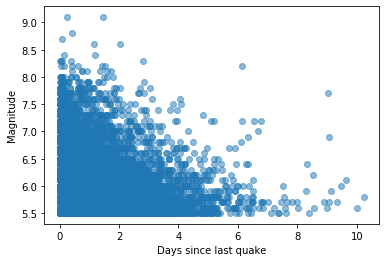

In [7]:
plt.scatter(df.Last_Quake_sec/(60*60*24),df.Magnitude, alpha=0.5)

plt.xlabel('Days since last quake')
plt.ylabel('Magnitude')
plt.show()

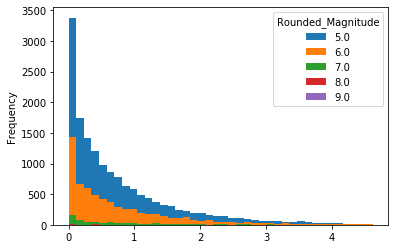

In [35]:
(df[df.Last_Quake_sec < 4*10**5].pivot(columns='Rounded_Magnitude')['Last_Quake_sec']/(60*60*24)).plot(kind = 'hist', stacked=False,bins=40)

plt.title('Stacked Barchart')
plt.xlabel('Time since last Quake (days)')

# Big quakes are preceeded by other quakes
    The hypothesis is **incorrect**. In fact, the longer time without a quake, the higher probability that the next quake will be small.

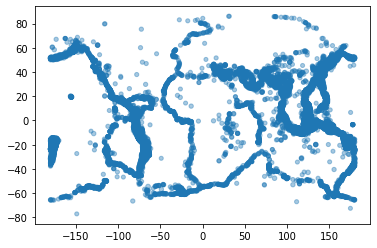

In [8]:
plt.scatter(df.Longitude.values,df.Latitude.values, alpha=0.4, s=3*df.Magnitude.values)

    This scatterplot shows the Latitude and Longitude coordinates of each quake in the dataset. The aggregated set clearly outlines the tectonic plates.
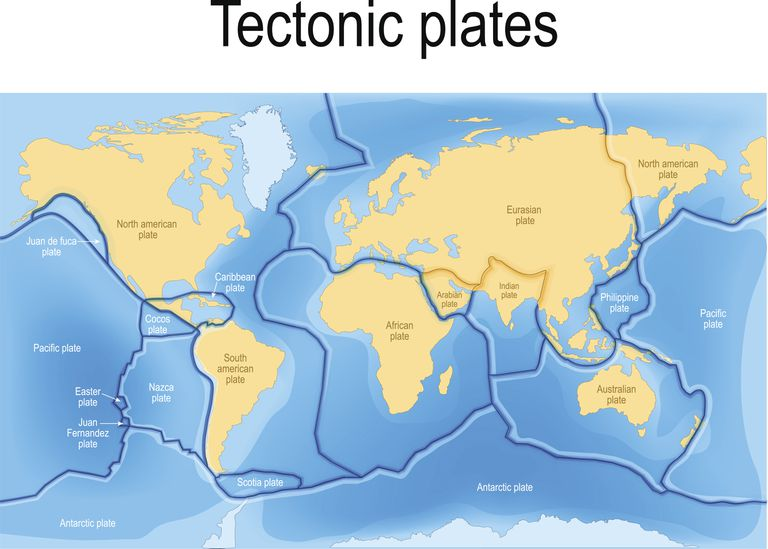

# Which city has greater danger of earthquakes: San Francisco or Tokyo?

## About the distance Funciton
    Subtracting latitude and longitude of a quake will not return the distance. This is the same effect that makes Greenland appear large on a 2d map.
    
    Instead Lat/Long points in spherical space are converted to an x,y,z triple in cartesian space. Then the euclidian distance between quakes and the reference point can be accuratly calculated.
    
    This method should more accuratly assess the proximity of the earthquake since the energy waves travel in a (nearly) straight line through the crust, not along the surface. It should be noted that this does not apply to earthquakes on the opposite side of the earth as the waves do not travel through earths molten core.

The above figure shows all earthquakes within 1 unit of Denver. The distance calculation assumes earth is a sphere with radius 1. A distance of sqrt(2)~=1.41 measures a hemisphere centered at the reference point. A distance of 2 includes the whole earth.

# How far away can you feel a strong quake?
The [US Geological Program (USGS)](https://earthquake.usgs.gov/learn/topics/mag-intensity/) cites that even large earhquakes dissapate quickly over an area. The tremors can hardly be felt more than just 100km or 1 degree away
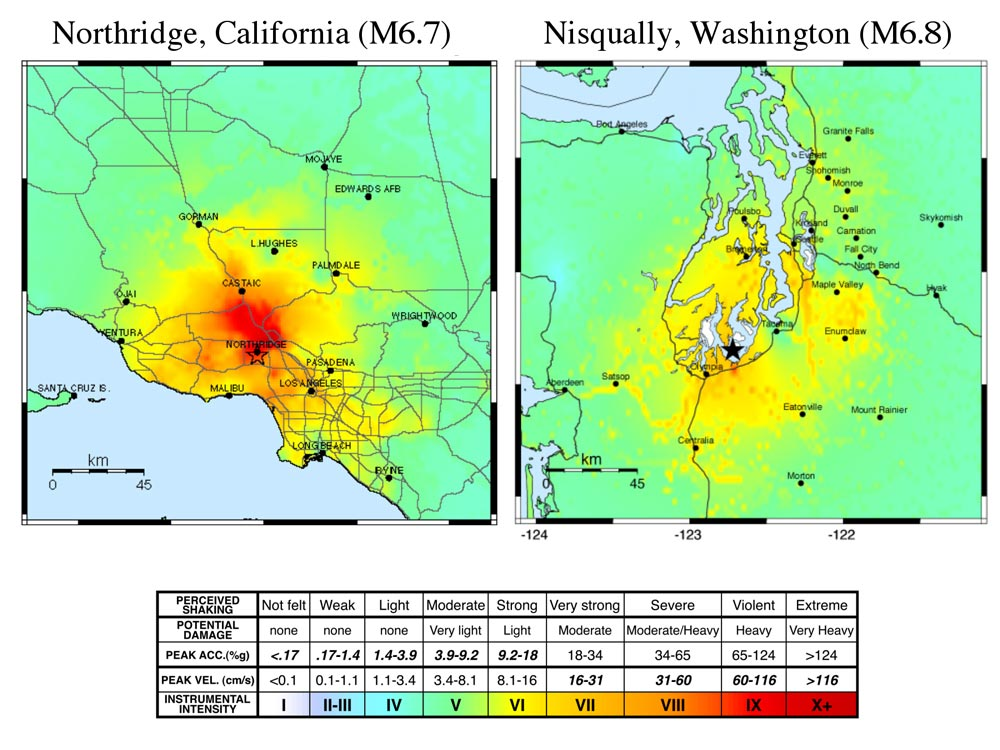

In [27]:
earth_radius = 6371 # kilometers
earth_circumfrence = earth_radius * 3.14 * 2
km_per_deg = earth_circumfrence / 360
print(100/km_per_deg)

0.8997777548945409


    More precicely, 100km == 0.899 deg. To include the effects of stronger quakes, the threshold for a 'local quake' will be set at 3 degrees.

In [32]:
q = pd.DataFrame.from_dict({'Latitude': [0], 'Longitude': [0]})
distance_from(q,0,3)

0    0.052354
dtype: float64

    3 degrees maps to 0.05 in the distance space.

In [25]:
print(San_Fran)
q = pd.DataFrame.from_dict({'Latitude': [San_Fran[0]], 'Longitude': [San_Fran[1]]})
distance_from(q,34.05,-118.24) # Distance to LA

[37.77, -122.42]


0    0.08774
dtype: float64

    For reference, the distance between SF and LA is 0.088

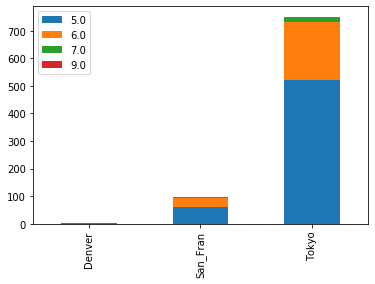

In [33]:
Local_Dist = .08

Denver_Local_Counts = df[df.Dist_Denver < Local_Dist].Rounded_Magnitude.value_counts()
San_Fran_Local_Counts = df[df.Dist_San_Fran < Local_Dist].Rounded_Magnitude.value_counts()
Tokyo_Local_Counts = df[df.Dist_Tokyo < Local_Dist].Rounded_Magnitude.value_counts()

counts = pd.concat({'Denver':Denver_Local_Counts, 'San_Fran':San_Fran_Local_Counts, 'Tokyo':Tokyo_Local_Counts}, axis = 1).fillna(0)
counts.transpose().plot(kind='bar',stacked=True)


# Tokyo has significantly more earthquakes than San Francisco or Denver